In [2]:
# Install required packages
!pip install pydriller transformers pandas -q


In [3]:
# Import libraries
import os, re, csv
from pydriller import Repository
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Define repo, paths, and settings
REPO_URL = "https://github.com/openai/gym.git"
REPO_DIR = "/kaggle/working/gym"
OUT_DIR  = "/kaggle/working/lab2_output"
os.makedirs(OUT_DIR, exist_ok=True)

COMMIT_CSV = os.path.join(OUT_DIR, "bug_fix_commits.csv")
DIFF_CSV   = os.path.join(OUT_DIR, "diff_analysis.csv")

MODEL_ID = "mamiksik/CommitPredictorT5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLORS = {"dev":"#ff8c00","llm":"#2e8b57","rect":"#c19a6b"}

In [ ]:
# Clone or update the repo
if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR} -q
else:
    !cd {REPO_DIR} && git pull -q

In [ ]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID).to(device)

def llm_message(diff):
    if not diff:
        return ""
    enc = tokenizer(diff, return_tensors="pt", truncation=True, max_length=512).to(device)
    out = model.generate(**enc, max_new_tokens=40, num_beams=3, early_stopping=True)
    return tokenizer.decode(out[0], skip_special_tokens=True).strip()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-09-04 07:50:54.170663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756972254.368546      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756972254.423228      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Rectifier function with threshold=10
GENERIC = re.compile(r"\b(update|change|modify|misc|stuff|minor|some|necessary)\b", re.I)
ACTION  = re.compile(r"\b(fix|resolve|handle|prevent|patch|correct|sanitize)\b", re.I)

def choose_message(dev_msg, llm_msg, threshold=10):
    d = (dev_msg or "").strip()
    l = (llm_msg or "").strip()
    d_len, l_len = len(d.split()), len(l.split())
    if d_len < 3 and l_len < 3: return "rectify"
    if d and GENERIC.search(d): return "rectify"
    if d_len >= threshold and d_len >= l_len: return "dev"
    if l_len >= threshold and l_len > d_len: return "llm"
    if ACTION.search(d) and not ACTION.search(l): return "dev"
    if ACTION.search(l) and not ACTION.search(d): return "llm"
    if d_len > l_len and d_len > 3: return "dev"
    if l_len > 3: return "llm"
    return "rectify"

In [ ]:

BUG_PATTERN = re.compile(
    r"\b("
    r"fix(e[sd]?|ing)?|"          # fix, fixed, fixes, fixing
    r"bug(s)?|typo(s)?|"          # bug, bugs, typo, typos
    r"error(s)?|erroneous|"       # error, errors, erroneous
    r"issue(s)?|ticket(s)?|"      # issue, issues, tickets
    r"patch(ed|es|ing)?|"         # patch, patched, patches, patching
    r"hotfix|"                    # hotfix
    r"correct(ed|ion)?|"          # correct, corrected, correction
    r"resolv(e[sd]?|ing)?|"       # resolve, resolved, resolving
    r"repair(ed|s|ing)?|"         # repair
    r"workaround|"                # workaround
    r"handle(d|s|ing)?|"          # handle, handled
    r"prevent(ed|s|ing)?|"        # prevent
    r"crash(es|ed|ing)?|"         # crash, crashed
    r"fail(ed|ure|s)?|"           # fail, failed, failure, fails
    r"exception(s)?|"             # exception, exceptions
    r"conflict(s)?|"              # conflict, conflicts
    r"problem(s)?"                # problem, problems
    r")\b",
    re.IGNORECASE
)

In [ ]:
# Collect bug-fix commits
commits = []
for c in Repository(REPO_DIR).traverse_commits():
    if BUG_PATTERN.search(c.msg or ""):
        parent = c.parents[0] if c.parents else ""
        files = []
        for mf in getattr(c, "modified_files", []):
            name = getattr(mf, "filename", None) or getattr(mf, "new_path", None) or getattr(mf, "old_path", None) or ""
            files.append(name)
        commits.append({"hash":c.hash,"msg":c.msg,"parent":parent,"merge":int(c.merge),"files":files,"obj":c})
    if len(commits) >= 200:
        break
print("Collected bug-fix commits:", len(commits))

Collected bug-fix commits: 200


In [ ]:
# Write commit-level CSV
with open(COMMIT_CSV,"w",newline="",encoding="utf-8") as f:
    w=csv.writer(f)
    w.writerow(["#","Message","Parent #","Merge Commit","Modified Files"])
    for c in commits:
        w.writerow([c["hash"],c["msg"],c["parent"],c["merge"],";".join([f for f in c["files"] if f])])
print("Wrote:",COMMIT_CSV)

Wrote: /kaggle/working/lab2_output/bug_fix_commits.csv


In [ ]:
# Check commit CSV structure using pandas
pd.read_csv(COMMIT_CSV).head()

,#,Message,Parent #,Merge Commit,Modified Files
0,c02a213f8ea8d8873e8045a089fae4ac2637b8b4,scoring.py: Handle entries without initial_res...,bd36a91603d5fe10ae6442ad41d264fabea44a32,0,scoring.py
1,1c816c9fe4c6cf3986890f0a19142bb3c3b08a8f,scoring.py: Handle entries without initial_res...,f9422ad0c6685ac27d7c76a5655fc7a3739c91e0,0,scoring.py
2,2c0b6cfbad8cd8a8067a50c3e15279e4d699d0bd,fix typo in cloning installation,a1e0c2519ef12190727c035ebee3a798f8b5d31f,0,README.rst
3,bcfefce9a091307596752e4585457659a1a19590,Merge pull request #2 from domluna/fix-cloning...,a1e0c2519ef12190727c035ebee3a798f8b5d31f,1,NaN
4,fa61141a57676b11cab3b0df135fa6898b97abac,Raise a better error for a missing pyglet,bcfefce9a091307596752e4585457659a1a19590,0,rendering.py


In [ ]:
# Write file-level CSV
dev_keep=llm_keep=rect_keep=0
with open(DIFF_CSV,"w",newline="",encoding="utf-8") as f:
    w=csv.writer(f)
    w.writerow(["#","Message","Filename","Source Code (before)","Source Code (current)","Diff","Fix Type (LLM)","Rectified Message"])
    for c in commits:
        for mf in getattr(c["obj"],"modified_files",[]):
            fname = getattr(mf,"filename",None) or getattr(mf,"new_path",None) or getattr(mf,"old_path",None) or ""
            before = getattr(mf,"source_code_before","") or ""
            after  = getattr(mf,"source_code","") or ""
            diff   = getattr(mf,"diff","") or ""
            llm_msg = llm_message(diff) if diff else ""
            decision = choose_message(c["msg"] or "", llm_msg)
            if decision=="dev": rect=c["msg"]; dev_keep+=1
            elif decision=="llm": rect=llm_msg; llm_keep+=1
            else:
                rect = f"{c['msg']}; {llm_msg}" if c["msg"] and llm_msg else (c["msg"] or llm_msg)
                rect_keep+=1
            w.writerow([c["hash"],c["msg"],fname,before,after,diff,llm_msg,rect])
print("Wrote:",DIFF_CSV)

Wrote: /kaggle/working/lab2_output/diff_analysis.csv


In [13]:
pd.read_csv(DIFF_CSV).head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
0,c02a213f8ea8d8873e8045a089fae4ac2637b8b4,scoring.py: Handle entries without initial_res...,scoring.py,"""""""This is the actual code we use to score peo...","""""""This is the actual code we use to score peo...","@@ -17,7 +17,8 @@ def score_from_remote(url):\...",fix bug in score_from_remote,scoring.py: Handle entries without initial_res...
1,1c816c9fe4c6cf3986890f0a19142bb3c3b08a8f,scoring.py: Handle entries without initial_res...,scoring.py,"""""""This is the actual code we use to score peo...","""""""This is the actual code we use to score peo...","@@ -17,7 +17,8 @@ def score_from_remote(url):\...",fix bug in score_from_remote,scoring.py: Handle entries without initial_res...
2,2c0b6cfbad8cd8a8067a50c3e15279e4d699d0bd,fix typo in cloning installation,README.rst,gym\n******\n\n**OpenAI Gym is a toolkit for d...,gym\n******\n\n**OpenAI Gym is a toolkit for d...,"@@ -37,7 +37,7 @@ You can perform a minimal in...",update gym.rb,fix typo in cloning installation
3,fa61141a57676b11cab3b0df135fa6898b97abac,Raise a better error for a missing pyglet,rendering.py,"""""""\n2D rendering framework\n""""""\nfrom __futur...","""""""\n2D rendering framework\n""""""\nfrom __futur...","@@ -10,7 +10,13 @@ if ""Apple"" in sys.version:\...",add note about installing gym dependencies,Raise a better error for a missing pyglet
4,ed2c3a1fdc36bc60cbe34f94efbb213e942755bb,README: Fix package name,README.rst,gym\n******\n\n**OpenAI Gym is a toolkit for d...,gym\n******\n\n**OpenAI Gym is a toolkit for d...,"@@ -74,7 +74,7 @@ On Ubuntu 14.04:\n \n .. cod...",add missing space in list of system names,README: Fix package name


In [ ]:
# Compute hit rates for Dev, LLM, Rectified
total=dev_keep+llm_keep+rect_keep
rq1 = (dev_keep/total*100) if total else 0
rq2 = (llm_keep/total*100) if total else 0
rq3 = (rect_keep/total*100) if total else 0

print("Total files analyzed:",total)
print(f"RQ1: Developer precise messages: {dev_keep} ({rq1:.2f}%)")
print(f"RQ2: LLM precise messages: {llm_keep} ({rq2:.2f}%)")
print(f"RQ3: Rectified precise messages: {rect_keep} ({rq3:.2f}%)")

Total files analyzed: 454
RQ1: Developer precise messages: 288 (63.44%)
RQ2: LLM precise messages: 18 (3.96%)
RQ3: Rectified precise messages: 148 (32.60%)


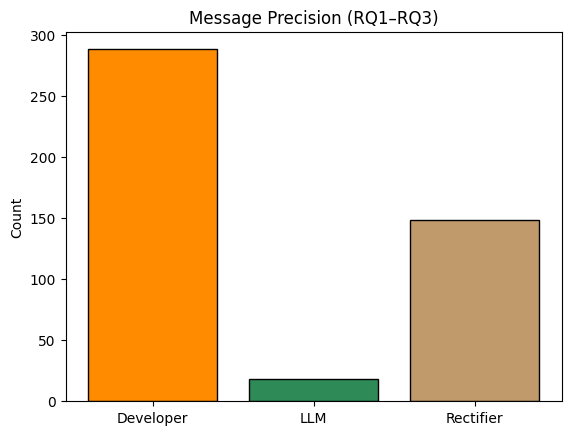

In [ ]:
# Plot counts
plt.bar(["Developer","LLM","Rectifier"],[dev_keep,llm_keep,rect_keep],
        color=[COLORS["dev"],COLORS["llm"],COLORS["rect"]],edgecolor="black")
plt.title("Message Precision (RQ1–RQ3)")
plt.ylabel("Count")
plt.show()